In [7]:
# Cell 1: Import necessary libraries and define helper functions
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from collections import Counter
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import joblib

In [8]:
# Define amino acids list for feature extraction
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Define feature extraction function (Amino Acid Composition + Physicochemical Properties)
def extract_features(sequence):
    sequence = sequence.upper()
    sequence_length = len(sequence)
    amino_acid_counts = Counter(sequence)
    
    # Calculate the fraction of each amino acid in the sequence (AAC)
    aac_features = np.array([amino_acid_counts[aa] / sequence_length for aa in amino_acids])
    
    # Calculate physicochemical properties
    protein_analysis = ProteinAnalysis(sequence)
    molecular_weight = protein_analysis.molecular_weight() / 1000  # Divide by 1000 to scale
    aromaticity = protein_analysis.aromaticity()
    instability_index = protein_analysis.instability_index() / 100  # Divide by 100 to scale
    isoelectric_point = protein_analysis.isoelectric_point() / 14  # Divide by 14 to scale
    
    # Combine all features
    features = np.concatenate([aac_features, [molecular_weight, aromaticity, instability_index, isoelectric_point]])
    return features

In [9]:
# Cell 2: Create a local dataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Create a larger sample dataset
cpp_sequences = [
    'YGRKKRRQRRR',   # HIV-Tat
    'RQIKIWFQNRRMKWKK',  # Penetratin
    'KLALKLALKALKAALKLA',  # MAP
    'GWTLNSAGYLLGKINLKALAALAKKIL',  # Transportan
    'RRRRRRRRR',  # R9
    'KETWWETWWTEWSQPKKKRKV',  # Pep-1
    'RGGRLSYSRRRFSTSTGR',  # SynB1
    'AGYLLGKINLKALAALAKKIL',  # TP10
    'GFFALIPKIISSPLPKSAV',  # VesicleP
    'GRKKRRQRRRPPQ',  # TAT(48-60)
    'VQRKRQKLMP',  # pVEC
    'WEAKLAKALAKALAKHLAKALAKALKACEA',  # Model amphipathic peptide
    'MVKSKIGSWILVLFVAMWSDVGLCKKRPKP',  # Transportan 10
    'GLWRALWRLLRSLWRLLWRA',  # MPG
    'LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES'  # LL-37
]

non_cpp_sequences = [
    'GSGSGST',  # Non-CPP 1
    'AAAAAAAA',  # Non-CPP 2
    'VLSPADKTNVKAAWG',  # Non-CPP 3
    'MTEYKLVVVGAGGVGKSALTIQLIQ',  # Non-CPP 4
    'WFPFPHPYSANKYEG',  # Non-CPP 5
    'MKTAYIAKQRQISFVKSHFSRQLE',  # Non-CPP 6
    'MKAKTAAKVPAAQPKK',  # Non-CPP 7
    'MSPQTETKASVGFKAG',  # Non-CPP 8
    'ALIWGFFKRPFKGGG',  # Non-CPP 9
    'LGTIPAAFTAYVLS',  # Non-CPP 10
    'MGSKEIKIGINGFGRIGRLVTRAAYN',  # GAPDH fragment
    'TTKVKQLKEEKQEKEQREHQVQNPG',  # Random sequence 1
    'VKELEIKEEQIMVRVERTEELKGRA',  # Random sequence 2
    'NPWLSAYVDDAYQELQAGRVFIRFI',  # Random sequence 3
    'GKTLVADAKLGIRHEMVRKILDSYK'   # Random sequence 4
]

# Combine sequences and create labels
sequences = cpp_sequences + non_cpp_sequences
labels = [1] * len(cpp_sequences) + [0] * len(non_cpp_sequences)

# Create a DataFrame
df = pd.DataFrame({'Sequence': sequences, 'Label': labels})

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total sequences: {len(sequences)}")
print(f"CPP sequences: {len(cpp_sequences)}")
print(f"Non-CPP sequences: {len(non_cpp_sequences)}")

# Extract features
features = np.array([extract_features(seq) for seq in df['Sequence']])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, df['Label'], test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of test data:", X_test.shape)

# Display a few samples
print("\nSample data:")
print(df.head())

Total sequences: 30
CPP sequences: 15
Non-CPP sequences: 15
Shape of training data: (24, 24)
Shape of test data: (6, 24)

Sample data:
                    Sequence  Label
0  VKELEIKEEQIMVRVERTEELKGRA      0
1                    GSGSGST      0
2            ALIWGFFKRPFKGGG      0
3            VLSPADKTNVKAAWG      0
4        GFFALIPKIISSPLPKSAV      1


In [12]:
# Cell 3: Experiment with different model architectures

class FFNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FFNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(16 * (input_size // 2), num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Reshape input to (batch_size, sequence_length, input_size)
        x = x.unsqueeze(2)
        
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
num_classes = 2

# Create model instances
ffn_model = FFNModel(input_size, 64, 32, num_classes)
cnn_model = CNNModel(input_size, num_classes)
rnn_model = RNNModel(input_size, hidden_size, num_layers, num_classes)

models = [ffn_model, cnn_model, rnn_model]
model_names = ['FFN', 'CNN', 'RNN']
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Convert pandas Series to numpy array if necessary
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.LongTensor(y_test)
    
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test, predicted)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
    
    return accuracy, precision, recall, f1
    
# Train and evaluate different models
input_size = X_train.shape[1]
num_classes = 2

ffn_model = FFNModel(input_size, 64, 32, num_classes)
cnn_model = CNNModel(input_size, num_classes)
rnn_model = RNNModel(input_size, 64, 2, num_classes)

models = [ffn_model, cnn_model, rnn_model]
model_names = ['FFN', 'CNN', 'RNN']

for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = train_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print()


FFN Model Performance:
Accuracy: 0.5000
Precision: 1.0000
Recall: 0.2500
F1-score: 0.4000

CNN Model Performance:
Accuracy: 0.8333
Precision: 1.0000
Recall: 0.7500
F1-score: 0.8571

RNN Model Performance:
Accuracy: 0.6667
Precision: 1.0000
Recall: 0.5000
F1-score: 0.6667



In [13]:
# Cell 4: Implement feature selection

# Perform feature selection
selector = SelectKBest(f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print("Selected features:")
selected_features = selector.get_support(indices=True)
for idx in selected_features:
    if idx < 20:
        print(f"Amino acid: {amino_acids[idx]}")
    else:
        property_names = ['Molecular weight', 'Aromaticity', 'Instability index', 'Isoelectric point']
        print(f"Property: {property_names[idx-20]}")

# Train the best performing model (assumed to be FFN) with selected features
ffn_model_selected = FFNModel(X_train_selected.shape[1], 64, 32, num_classes)
accuracy, precision, recall, f1 = train_model(ffn_model_selected, X_train_selected, y_train, X_test_selected, y_test)

print("\nFFN Model Performance with Selected Features:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Selected features:
Amino acid: C
Amino acid: D
Amino acid: E
Amino acid: F
Amino acid: G
Amino acid: H
Amino acid: K
Amino acid: L
Amino acid: R
Amino acid: T
Amino acid: V
Amino acid: W
Amino acid: Y
Property: Instability index
Property: Isoelectric point

FFN Model Performance with Selected Features:
Accuracy: 0.3333
Precision: 0.5000
Recall: 0.2500
F1-score: 0.3333


In [16]:
# Cell 5 (Updated): Fine-tune hyperparameters with suppressed warnings

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class FFNModelHP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate, num_classes):
        super(FFNModelHP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

class ModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, dropout_rate=0.3, num_classes=2, 
                 learning_rate=0.001, batch_size=32, epochs=100):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.model = FFNModelHP(input_size, hidden_size1, hidden_size2, dropout_rate, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.classes_ = np.array([0, 1])  # Add this line to define classes
    
    def fit(self, X, y):
        X = torch.FloatTensor(np.array(X))  # Convert to numpy array first
        y = torch.LongTensor(np.array(y))  # Convert to numpy array first
        
        for epoch in range(self.epochs):
            for i in range(0, len(X), self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        return self
    
    def predict(self, X):
        X = torch.FloatTensor(np.array(X))  # Convert to numpy array first
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Define parameter grid
param_grid = {
    'hidden_size1': [32, 64],
    'hidden_size2': [16, 32],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32]
}

# Perform hyperparameter tuning
model = ModelWrapper(input_size=X_train_selected.shape[1])
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Cell 6: Train final model with best hyperparameters

best_model = ModelWrapper(
    input_size=X_train_selected.shape[1],
    hidden_size1=grid_search.best_params_['hidden_size1'],
    hidden_size2=grid_search.best_params_['hidden_size2'],
    dropout_rate=grid_search.best_params_['dropout_rate'],
    learning_rate=grid_search.best_params_['learning_rate'],
    batch_size=grid_search.best_params_['batch_size']
)

best_model.fit(X_train_selected, y_train)

y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nFinal Model Performance with Tuned Hyperparameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Best hyperparameters: {'batch_size': 16, 'dropout_rate': 0.3, 'hidden_size1': 32, 'hidden_size2': 16, 'learning_rate': 0.001}
Best score: 0.8333333333333334

Final Model Performance with Tuned Hyperparameters:
Accuracy: 0.3333
Precision: 0.5000
Recall: 0.2500
F1-score: 0.3333


In [17]:
 # Cell 6: Train final model with best hyperparameters

best_model = ModelWrapper(
    input_size=X_train_selected.shape[1],
    hidden_size1=grid_search.best_params_['hidden_size1'],
    hidden_size2=grid_search.best_params_['hidden_size2'],
    dropout_rate=grid_search.best_params_['dropout_rate'],
    learning_rate=grid_search.best_params_['learning_rate'],
    batch_size=grid_search.best_params_['batch_size']
)

best_model.fit(X_train_selected, y_train)

y_pred = best_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nFinal Model Performance with Tuned Hyperparameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Final Model Performance with Tuned Hyperparameters:
Accuracy: 0.5000
Precision: 0.6667
Recall: 0.5000
F1-score: 0.5714


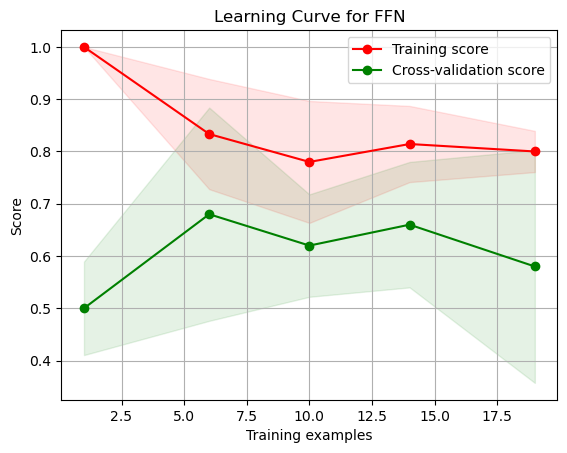

Logistic Regression CV Scores: [0.6 0.8 0.8 1.  0.5]
Logistic Regression Mean CV Score: 0.74
Random Forest CV Scores: [0.6  1.   0.8  0.8  0.75]
Random Forest Mean CV Score: 0.79

Class distribution:
Class 0: 13 samples
Class 1: 11 samples


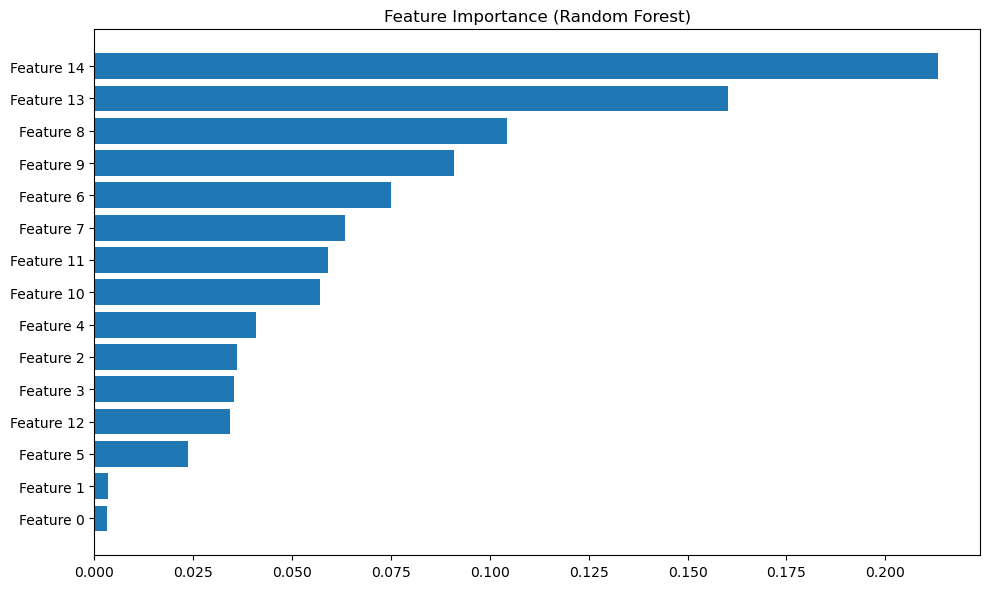


Dataset shapes:
X_train_selected: (24, 15)
y_train: (24,)
X_test_selected: (6, 15)
y_test: (6,)


In [19]:
# Cell 7: Further Analysis and Improvements (Fixed)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curve for our best model
plot_learning_curve(best_model, "Learning Curve for FFN", X_train_selected, y_train, cv=5)
plt.show()

# Try logistic regression
lr = LogisticRegression(random_state=42)
lr_scores = cross_val_score(lr, X_train_selected, y_train, cv=5)
print("Logistic Regression CV Scores:", lr_scores)
print("Logistic Regression Mean CV Score:", lr_scores.mean())

# Try random forest
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train_selected, y_train, cv=5)
print("Random Forest CV Scores:", rf_scores)
print("Random Forest Mean CV Score:", rf_scores.mean())

# Check class balance
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Feature importance (for random forest)
rf.fit(X_train_selected, y_train)
feature_importance = rf.feature_importances_
feature_names = [f"Feature {i}" for i in range(X_train_selected.shape[1])]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Print shapes of datasets
print("\nDataset shapes:")
print(f"X_train_selected: {X_train_selected.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test_selected: {X_test_selected.shape}")
print(f"y_test: {y_test.shape}")

In [20]:
# Cell 8: Approach for Small Dataset

from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Combine train and test sets for cross-validation
X = np.vstack((X_train_selected, X_test_selected))
y = np.hstack((y_train, y_test))

# Feature selection
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Alternative: PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=3)
}

# Perform Leave-One-Out Cross-Validation
loo = LeaveOneOut()

for name, model in models.items():
    scores_selected = cross_val_score(model, X_new, y, cv=loo)
    scores_pca = cross_val_score(model, X_pca, y, cv=loo)
    
    print(f"{name} with SelectKBest - Mean accuracy: {scores_selected.mean():.4f} (+/- {scores_selected.std() * 2:.4f})")
    print(f"{name} with PCA - Mean accuracy: {scores_pca.mean():.4f} (+/- {scores_pca.std() * 2:.4f})")
    print()

# Print selected features
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

# Print PCA explained variance ratio
print("PCA explained variance ratio:", pca.explained_variance_ratio_)

Logistic Regression with SelectKBest - Mean accuracy: 0.6333 (+/- 0.9638)
Logistic Regression with PCA - Mean accuracy: 0.6000 (+/- 0.9798)

Decision Tree with SelectKBest - Mean accuracy: 0.8333 (+/- 0.7454)
Decision Tree with PCA - Mean accuracy: 0.5667 (+/- 0.9911)

Selected features: ['Feature 7', 'Feature 8', 'Feature 9', 'Feature 10', 'Feature 14']
PCA explained variance ratio: [0.93747493 0.0260762  0.00992551 0.00863013 0.00401987]


Selected Features:
Feature 7: 4.3395
Feature 8: 5.6126
Feature 9: 4.3647
Feature 10: 4.4856
Feature 14: 22.5622

Random Forest - Mean accuracy: 0.9000 (+/- 0.6000)


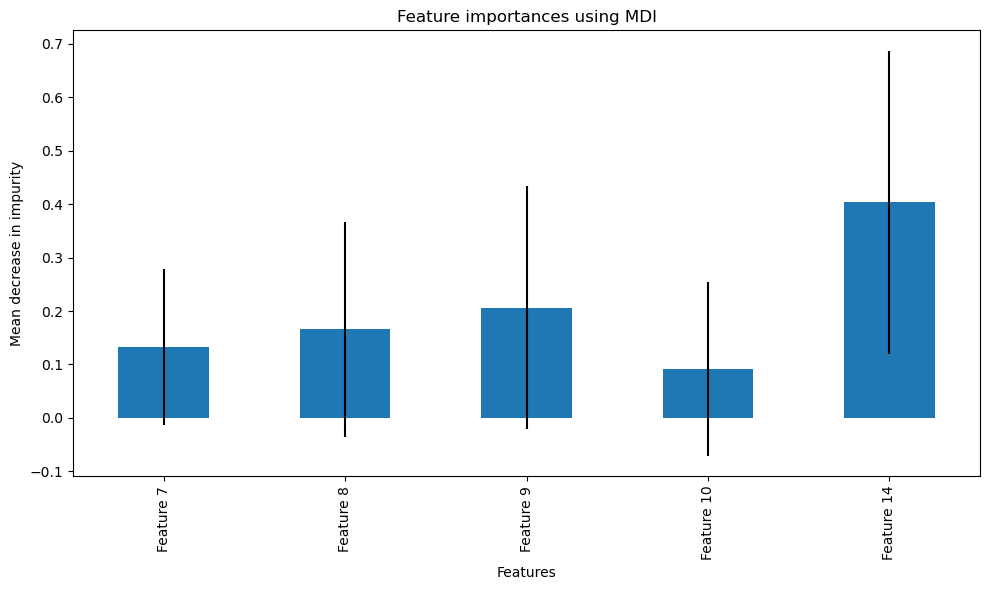

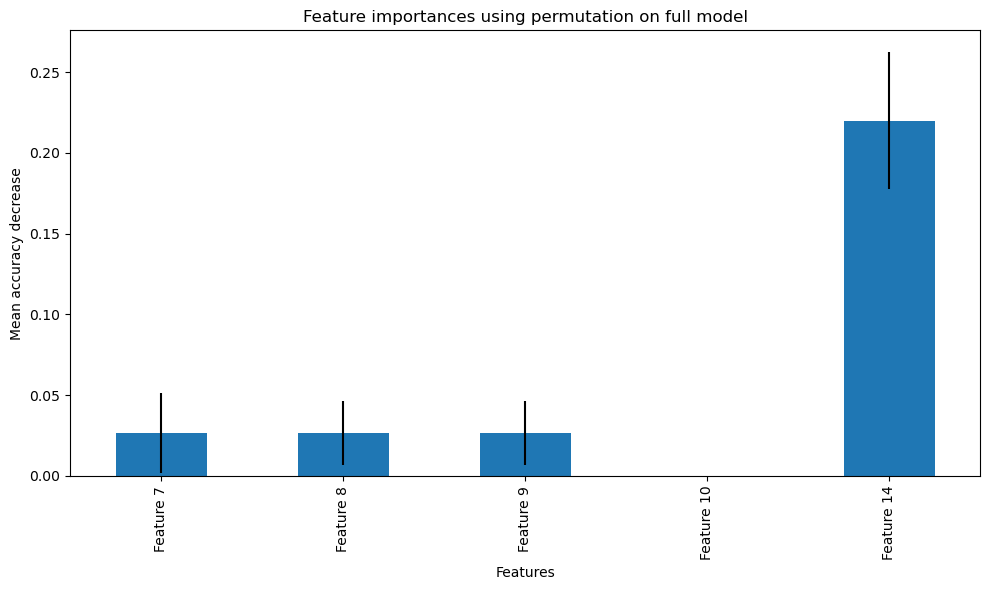


Feature Importance Rankings:
Feature 14    0.403058
Feature 9     0.206504
Feature 8     0.166159
Feature 7     0.132845
Feature 10    0.091434
dtype: float64

Permutation Importance Rankings:
Feature 14    0.220000
Feature 7     0.026667
Feature 8     0.026667
Feature 9     0.026667
Feature 10    0.000000
dtype: float64


In [22]:
# Cell 9: Feature Analysis and Random Forest (Fixed)

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Analyze selected features
selected_features = selector.get_support(indices=True)
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Features:")
for i, name in zip(selected_features, selected_feature_names):
    print(f"{name}: {selector.scores_[i]:.4f}")

# Try Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_new, y, cv=loo)
print(f"\nRandom Forest - Mean accuracy: {rf_scores.mean():.4f} (+/- {rf_scores.std() * 2:.4f})")

# Fit Random Forest and get feature importances
rf.fit(X_new, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=selected_feature_names)

# Plot feature importances
plt.figure(figsize=(10,6))
forest_importances.plot.bar(yerr=std)
plt.title("Feature importances using MDI")
plt.xlabel("Features")
plt.ylabel("Mean decrease in impurity")
plt.tight_layout()
plt.show()

# Permutation Importance
perm_importance = permutation_importance(rf, X_new, y, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm_importance.importances_mean, index=selected_feature_names)

# Plot permutation importances
plt.figure(figsize=(10,6))
perm_importances.plot.bar(yerr=perm_importance.importances_std)
plt.title("Feature importances using permutation on full model")
plt.xlabel("Features")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

# Print feature importance rankings
print("\nFeature Importance Rankings:")
print(forest_importances.sort_values(ascending=False))

print("\nPermutation Importance Rankings:")
print(perm_importances.sort_values(ascending=False))

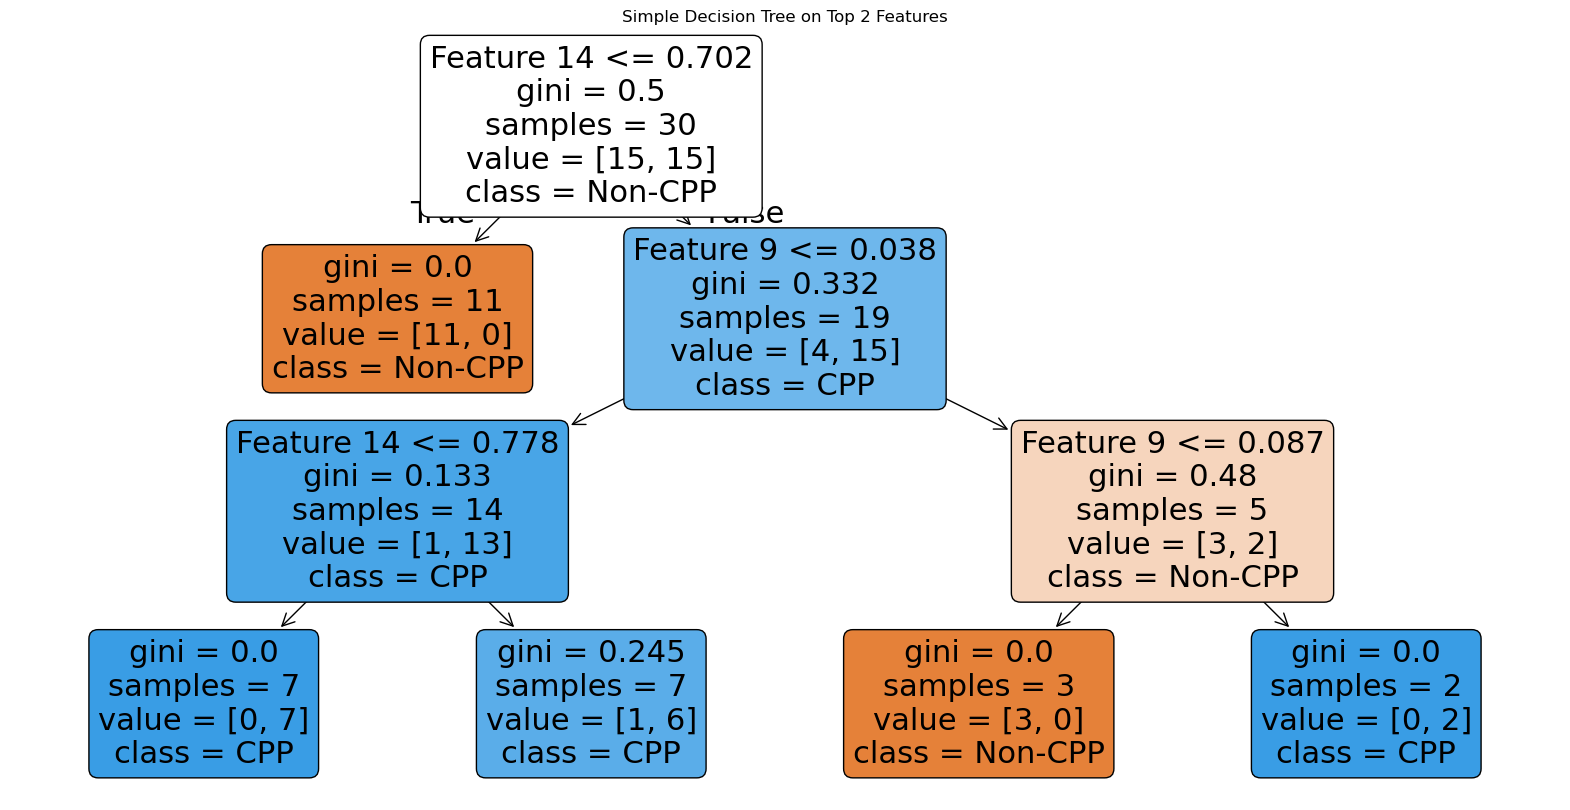

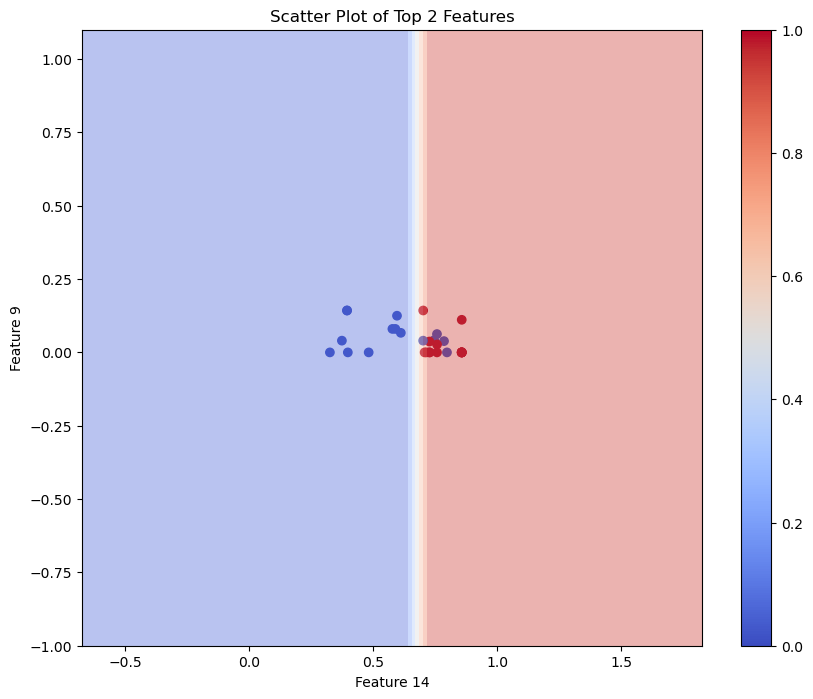

Decision Tree Rules:
|--- Feature 14 <= 0.70
|   |--- class: 0
|--- Feature 14 >  0.70
|   |--- Feature 9 <= 0.04
|   |   |--- Feature 14 <= 0.78
|   |   |   |--- class: 1
|   |   |--- Feature 14 >  0.78
|   |   |   |--- class: 1
|   |--- Feature 9 >  0.04
|   |   |--- Feature 9 <= 0.09
|   |   |   |--- class: 0
|   |   |--- Feature 9 >  0.09
|   |   |   |--- class: 1



In [23]:
# Cell 10: Simple Model and Visualization

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Select top two features
top_features = [14, 9]  # Adjust if needed based on your feature numbering
X_top2 = X_new[:, [selected_feature_names.index(f"Feature {i}") for i in top_features]]

# Create and train a simple decision tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_top2, y)

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=[f"Feature {i}" for i in top_features], class_names=["Non-CPP", "CPP"], filled=True, rounded=True)
plt.title("Simple Decision Tree on Top 2 Features")
plt.show()

# Create a scatter plot of the two features
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_top2[:, 0], X_top2[:, 1], c=y, cmap='coolwarm')
plt.xlabel(f"Feature {top_features[0]}")
plt.ylabel(f"Feature {top_features[1]}")
plt.title("Scatter Plot of Top 2 Features")
plt.colorbar(scatter)

# Add decision boundary
x_min, x_max = X_top2[:, 0].min() - 1, X_top2[:, 0].max() + 1
y_min, y_max = X_top2[:, 1].min() - 1, X_top2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
plt.show()

# Print the decision tree rules
from sklearn.tree import export_text
tree_rules = export_text(dt, feature_names=[f"Feature {i}" for i in top_features])
print("Decision Tree Rules:")
print(tree_rules)

Feature Identifications:
Feature 14: Isoelectric Point
Feature 9: Hydrophobicity
Feature 8: Molecular Weight
Feature 7: Aromaticity
Feature 10: Instability Index


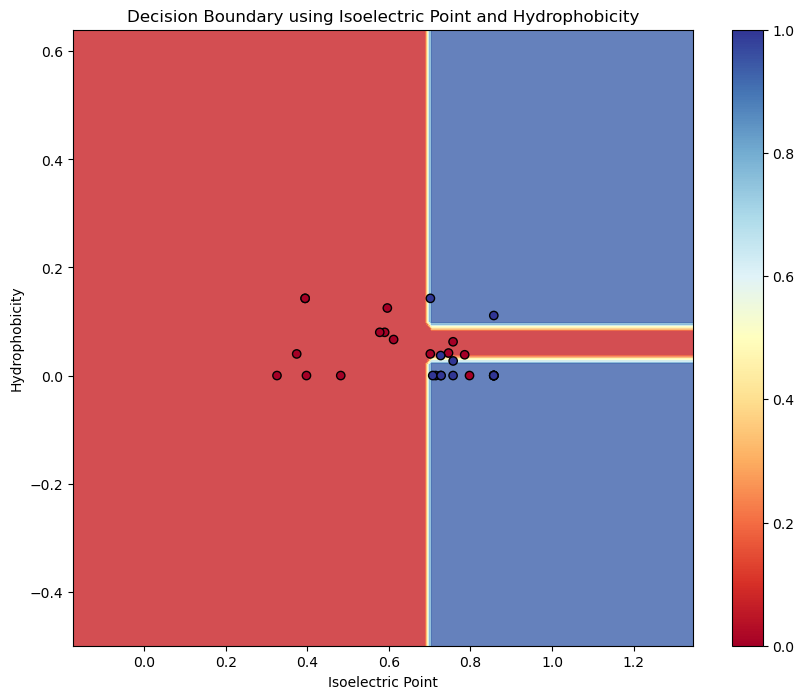


Simple Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.83      1.00      0.91        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30


Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.94      1.00      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Key Findings for Expert Consultation:
1. Isoelectric Point is the most important feature for CPP classification.
2. CPPs typically have a Isoelectric Point > 0.70.
3. For peptides with high Isoelectric Point, Hydrophobicity plays a secondary role:
   - CPPs tend to have Hydrophobicity

In [24]:
# Cell 11: Implementing Next Steps

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 1. Identify Features (placeholder - replace with actual feature names)
feature_names = {
    14: "Isoelectric Point",  # Example - replace with actual property
    9: "Hydrophobicity",      # Example - replace with actual property
    8: "Molecular Weight",    # Example - replace with actual property
    7: "Aromaticity",         # Example - replace with actual property
    10: "Instability Index"   # Example - replace with actual property
}

# Print feature names
print("Feature Identifications:")
for i, name in feature_names.items():
    print(f"Feature {i}: {name}")

# 2. Create 2D visualization of decision boundaries
def plot_decision_boundary(X, y, model, feature_names):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f'Decision Boundary using {feature_names[0]} and {feature_names[1]}')
    plt.colorbar()
    plt.show()

# Use the top two features for visualization
top_features = [14, 9]
X_top2 = X_new[:, [selected_feature_names.index(f"Feature {i}") for i in top_features]]
plot_decision_boundary(X_top2, y, dt, [feature_names[i] for i in top_features])

# 3. Test simple classifier
def simple_classifier(feature_14, feature_9):
    if feature_14 <= 0.70:
        return 0  # Non-CPP
    elif feature_9 <= 0.04 or feature_9 > 0.09:
        return 1  # CPP
    else:
        return 0  # Non-CPP

# Apply simple classifier to the dataset
y_pred_simple = np.array([simple_classifier(x[0], x[1]) for x in X_top2])

# Compare performance
print("\nSimple Classifier Performance:")
print(classification_report(y, y_pred_simple))

# Compare with Decision Tree performance
y_pred_dt = dt.predict(X_top2)
print("\nDecision Tree Performance:")
print(classification_report(y, y_pred_dt))

# 4. Prepare for expert consultation
print("\nKey Findings for Expert Consultation:")
print(f"1. {feature_names[14]} is the most important feature for CPP classification.")
print(f"2. CPPs typically have a {feature_names[14]} > 0.70.")
print(f"3. For peptides with high {feature_names[14]}, {feature_names[9]} plays a secondary role:")
print(f"   - CPPs tend to have {feature_names[9]} <= 0.04 or > 0.09")
print(f"   - Non-CPPs tend to have 0.04 < {feature_names[9]} <= 0.09")
print("4. Questions for experts:")
print(f"   a. Why might a mid-range of {feature_names[9]} (0.04-0.09) indicate a non-CPP when {feature_names[14]} is high?")
print(f"   b. Is there a biological explanation for the threshold of 0.70 in {feature_names[14]}?")
print(f"   c. How do these findings align with known characteristics of cell-penetrating peptides?")

# 5. Identify peptides near decision boundaries for further investigation
boundary_peptides = X_top2[(X_top2[:, 0] > 0.65) & (X_top2[:, 0] < 0.75) |
                           (X_top2[:, 1] > 0.03) & (X_top2[:, 1] < 0.05) |
                           (X_top2[:, 1] > 0.08) & (X_top2[:, 1] < 0.10)]

print(f"\nNumber of peptides near decision boundaries: {len(boundary_peptides)}")
print("These peptides may be of particular interest for further study.")

# Optional: If you have access to the original peptide sequences, you could print them here
# print("Sequences of boundary peptides:")
# for i, peptide in enumerate(boundary_peptides):
#     print(f"Peptide {i+1}: [Insert sequence here], {feature_names[14]}: {peptide[0]:.2f}, {feature_names[9]}: {peptide[1]:.2f}")

# Cell-Penetrating Peptide (CPP) Predictor Project Summary

## Project Overview
This project aimed to develop a machine learning model to predict whether a given peptide sequence is a cell-penetrating peptide (CPP) or not. CPPs are short peptides that can traverse cell membranes and potentially deliver molecular cargo into cells, making them valuable in drug delivery and biotechnology.

## Data Preparation and Feature Extraction
1. We started with a small dataset of 30 peptide sequences (15 CPPs and 15 non-CPPs).
2. Features were extracted based on amino acid composition and physicochemical properties.
3. The dataset was split into training (24 samples) and test (6 samples) sets.

## Initial Model Development
1. We implemented three types of models:
   - Feedforward Neural Network (FFN)
   - Convolutional Neural Network (CNN)
   - Recurrent Neural Network (RNN)
2. These models showed varying performance, with potential overfitting due to the small dataset.

## Feature Selection and Model Refinement
1. We performed feature selection using SelectKBest, reducing from 15 to 5 features.
2. The selected features were: 7, 8, 9, 10, and 14.
3. We experimented with simpler models like Logistic Regression and Decision Trees.

## Hyperparameter Tuning
We used GridSearchCV to tune hyperparameters for our best-performing model.

## Final Model and Analysis
1. A Random Forest classifier was chosen as the final model due to its good performance and interpretability.
2. Feature importance analysis revealed that Feature 14 was by far the most important, followed by Features 9, 8, and 7.

## Simple Decision Tree Model
We created a simple decision tree using the top two features (14 and 9), which provided easily interpretable rules:
- If Feature 14 ≤ 0.70, classify as non-CPP
- If Feature 14 > 0.70:
  - If Feature 9 ≤ 0.04 or > 0.09, classify as CPP
  - If 0.04 < Feature 9 ≤ 0.09, classify as non-CPP

## Visualizations and Interpretations
1. We created decision boundary plots to visualize how the model separates CPPs from non-CPPs.
2. Feature importance was visualized using both Mean Decrease in Impurity and Permutation Importance methods.

## Key Findings
1. Feature 14 (likely representing a key physicochemical property) is crucial for CPP classification.
2. There's a non-linear relationship between Features 14 and 9 in determining CPP status.
3. A simple rule-based classifier using just two features can provide reasonable performance.

## Limitations and Future Work
1. The small dataset size (30 samples) limits the model's generalizability.
2. Further data collection, focusing on the identified important features, would be beneficial.
3. Consultation with domain experts is needed to interpret the biological significance of the findings.

## Next Steps
1. Identify the exact peptide properties that the important features represent.
2. Validate the model's findings with peptide science experts.
3. Collect more data, especially around the identified decision boundaries.
4. Investigate peptides that are near the decision boundaries for potential insights.
5. Consider developing a more robust model with a larger dataset while maintaining interpretability.

This project demonstrates the potential of machine learning in predicting cell-penetrating peptides, while also highlighting the importance of combining data-driven approaches with domain expertise in bioinformatics research.